<a href="https://colab.research.google.com/github/amandaverissimo/analise-migratoria/blob/main/Vers%C3%A3o_final_de_MVP_Engenharia_de_dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dados Migratórios no Brasil: de janeiro de 2022 a junho de 2024

As informações contidas nesse Notebook descrevem o pipeline de ETL para os dados de Movimento Migratório no Brasil: registros ativos de imigrantes e movimento de entrada no país a partir de registros nos postos da Polícia Federal.

###Contexto:
Ao andar pelas ruas das grandes metrópoles brasileiras é possível identificar traços e sotaques variados, atribuidos às mais diversas nacionalidades. Percebe-se no cotidiano das cidades a presença de pessoas estrangeiras no país, seja por turismo – à passeio, pedindo informações - ou para (maior) permanência – prestando serviços e até em situação de vulnerabilidade. É possível apontar como Problema o planejamento de recursos e serviços para imigrantes no Brasil. Nesse sentido proponho confrontar os dados extraídos do Sistema de Tráfego Internacional e do Sistema de Registro Nacional Migratório para melhor percepção e análise dos movimentos migratórios no país entre janeiro de 2022 e junho de 2024. <br>
<br>

###Objetivo:
Fazer uma análise comparativa entre o tráfego internacional de pessoas e os registos ativos de imigrantes, considerando o escopo temporal das bases de dados do STI e SISMIGRA - jan/22 a jun/2024. As Perguntas que esse trabalho visa responder são:
1. Os movimentos migratórios para o Brasil têm aumentado ou diminuido?
2. Considerando UF de entrada como local de permanência: quais regiões precisam de mais recursos para lidar com a alta concentração de imigrantes registrados?
3. Quais os períodos de mais registros ativos de imigrantes?
4. A partir da nacionalidade com maior ocorrencia de migração é possível inferir a motivação desse movimento para o Brasil?
5. Qual a porcentagem de migração permanente para o Brasil em meio aos demais tipos de entrada no país?
6. Qual a proporção de emigrantes brasileiros para imigrantes estrangeiros?
<br>
<br>

###Descrição dos Dados:

Dados de domínio público extraídos da plataforma Gov.br, do Governo Federal.
Dados Abertos, inseridos no STI - Sistema de tráfego internacional e SISMIGRA - Sistema de Registro Nacional Migratório, organizados pelo DPF – departamento de Polícia Federal.<br>
<br>
Os dados do Sistema de tráfego internacional e do Sistema de Registro Nacional Migratório se apresentam em formato CSV. <br>
<br>
**Fonte**: Dados do STI: https://servicos.dpf.gov.br/dadosabertos/STI/ <br>
Dados do SISMIGRA: https://servicos.dpf.gov.br/dadosabertos/SISMIGRA/<br>
<br>

####Dados STI
Foram coletados 30 arquivos a serem explorados. Os dados estão segmentados por escopo temporal (mensal) - cada um dos documentos corresponde ao movimento migratório nas fronteiras brasileiras em determinado mês do ano – de 01/2022 a 06/2024.<br>
Cada um dos arquivos exibe os seguintes dados:<br>
UF_ATENDIMENTO: em qual unidade federativa se deu o movimento de entrada ou saída do Brasil.<br>
TIPO: Tipo de movimentação – de entrada ou saída do país. <br>
CLASSIFICACAO: Qual o objetivo do movimento (e “status” do indivíduo): de permanência, visita, ou permanencia temporária no Brasil ou ainda outras finalidades (não especificadas). <br>
NACIONALIDADE: Qual a origem do indivíduo que realizou o movimento migratório.<br>
TOTAL: Total de movimentos / indivíduos registrados pelo STI. <br>
<br>

####Dados SISMIGRA
Foram coletados 30 arquivos a serem explorados. Os dados estão segmentados por escopo temporal (mensal) - cada um dos documentos corresponde ao número de registros ativos de imigrantes em determinado mês do ano – de 01/2022 a 06/2024.
Cada um dos arquivos exibe os seguintes dados:<br>
UF: Unidade federativa em que o imigrante foi admitido<br>
NACIONALIDADE: País de nacionalidade do imigrante<br>
CLASSIFICACAO: Situação do imigrante - residente, temporário, provisório e fronteiriço<br>
QTD: Quantidade de imigrantes admitidos<br>
<br>
<br>
**Pipeline de ETL**



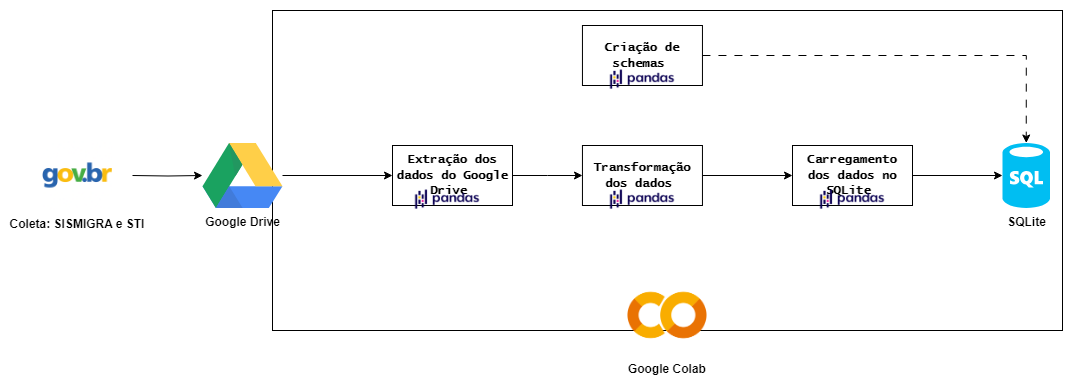

Abaixo o código comentado:

In [ ]:
# Instalação da biblioteca SQLite
!pip install pysqlite3

In [ ]:
# Instalação do banco de dados SQLite
!pip install db-sqlite3

###Extração dos dados (E) - Transformação dos dados (T) - Carregamento dos dados (L) - Dataset SISMIGRA:

In [ ]:
#E. Montando o Drive no Colab para que arquivos do Google Drive possam ser utilizados
import pandas as pd
from google.colab import drive
import os
import pandas as pd
drive.mount("/content/drive", force_remount=True)

In [7]:
# E. Importação das bibliotecas necessárias para execução
import os
import pandas as pd
import pysqlite3
import sqlite3
from sqlalchemy import create_engine, Integer, String, Text

# E. Caminho para a pasta contendo os arquivos CSV no Google Drive
folder_path = "/content/drive/My Drive/Colab Notebooks/Datasets MVP Engenharia de Dados/SISMIGRA_Registros_Ativos"

# E. Listando todos os arquivos CSV na pasta (acrescido de "sorted" para que uma ordem seja seguida)
csv_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])

# T. Lista para armazenar os DataFrames - arquivos csv serão concatenados em um Dataframe
dfs = []

for file in csv_files:
   #T. Especificando caminho completo: pasta e arquivo
  file_path = os.path.join(folder_path, file)

  #T. nomeando as tabelas a partir do nome do arquivo
  name_clean = file.replace(".csv", "")
  name_list = name_clean.split("_")

  # T. Lendo arquivo CSV
  df = pd.read_csv(file_path, sep=";", header=0)

  # T. Explicitando concatenação das colunas ano e mês (aaaa-mm)
  df['MES'] = name_list[-1] + "-" + name_list[-2]

  # T. Adicionando o DataFrame à lista vazia
  dfs.append(df)

# T. Concatenando todos os DataFrames
  combined_df = pd.concat(dfs, ignore_index=True)

# L. Conectando ao banco de dados SQLite
engine = create_engine('sqlite:////content/drive/My Drive/Colab Notebooks/Versão Final MVP/SISMIGRA_Registros_Ativos.db')

# L. Estabelecendo conexão bruta com o banco de dados
raw_conn = engine.raw_connection()

# L. Criando cursor para a conexão bruta
cursor = raw_conn.cursor()

cursor.execute('DROP TABLE IF EXISTS SISMIGRA_Registros_Ativos;')

# Add constraints - Criando nova tabela
cursor.execute('''
    CREATE TABLE SISMIGRA_Registros_Ativos (
        UF STRING NOT NULL,
        NACIONALIDADE STRING NOT NULL,
        CLASSIFICACAO STRING NOT NULL,
        QTD INTEGER NOT NULL,
        MES STRING NOT NULL,
        CONSTRAINT PK_SISMIGRA PRIMARY KEY (NACIONALIDADE, CLASSIFICACAO, MES)
    );
''')

# L. Salvando o DataFrame como tabela no banco de dados
combined_df.to_sql('SISMIGRA_Registros_Ativos', raw_conn, if_exists='replace', index=False)
# L. Salvando o DataFrame como arquivo csv no banco de dados
combined_df.to_csv('/content/drive/My Drive/Colab Notebooks/Versão Final MVP/SISMIGRA_Registros_Ativos.csv', index=False)

# Verificação da tabela salva
df_from_db = pd.read_sql('SELECT * FROM SISMIGRA_Registros_Ativos', raw_conn)
print(df_from_db.tail())
print(df_from_db.info())

# Fechando conexão com banco de dados
raw_conn.close()


<ipython-input-7-9004eeb23750>:61: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  combined_df.to_sql('SISMIGRA_Registros_Ativos', raw_conn, if_exists='replace', index=False)
<ipython-input-7-9004eeb23750>:66: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_from_db = pd.read_sql('SELECT * FROM SISMIGRA_Registros_Ativos', raw_conn)


        UF NACIONALIDADE CLASSIFICACAO  QTD      MES
177058  AC          GANA     Residente    1  06-2024
177059  PB      HONDURAS    Temporário    2  06-2024
177060  RJ     MACEDÔNIA    Temporário    1  06-2024
177061  RJ    MAURITÂNIA     Residente    1  06-2024
177062  PA       ARGÉLIA    Temporário    1  06-2024
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177063 entries, 0 to 177062
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   UF             177063 non-null  object
 1   NACIONALIDADE  177063 non-null  object
 2   CLASSIFICACAO  177063 non-null  object
 3   QTD            177063 non-null  int64 
 4   MES            177063 non-null  object
dtypes: int64(1), object(4)
memory usage: 6.8+ MB
None



###Extração dos dados (E) - Transformação dos dados (T) - Carregamento dos dados (L) - Dataset STI:

In [9]:
# E. Importanto bibliotecas necessárias para execução
import pandas as pd
import os
from sqlalchemy import create_engine

# E. Caminho para a pasta contendo os arquivos CSV no Google Drive
folder_path = "/content/drive/My Drive/Colab Notebooks/Datasets MVP Engenharia de Dados/STI Movimento"

# E. Listando todos os arquivos CSV na pasta (acrescido de "sorted" para que uma ordem seja seguida)
csv_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])

# T. Lista para armazenar os DataFrames - arquivos csv serão concatenados em um Dataframe
dfs = []

for file in csv_files:
     # T. Especificando caminho completo para o arquivo
    file_path = os.path.join(folder_path, file)

    # T. Nomeando as tabelas a partir do nome do arquivo
    name_clean = file.replace(".csv", "")
    name_list = name_clean.split("_")

    # T. Lendo arquivo CSV com codificação "ANSI" ('cp1252')
    df = pd.read_csv(file_path, sep=";", header=0, encoding='cp1252' )

    # T. Adicionando novas colunas baseadas no nome do arquivo
    df['MES'] = name_list[-1] + "-" + name_list[-2]

    # T. Adicionando o DataFrame à lista
    dfs.append(df)

    # T. Concatenação de todos os DataFrames
    combined_df = pd.concat(dfs, ignore_index=True)

# T. Removendo espaços em branco das colunas
combined_df['TIPO'] = combined_df['TIPO'].str.strip()
combined_df['CLASSIFICACAO'] = combined_df['CLASSIFICACAO'].str.strip()
combined_df['NACIONALIDADE'] = combined_df['NACIONALIDADE'].str.strip()

# T. Filtrando as linhas onde a coluna NACIONALIDADE não está vazia
combined_df = combined_df.loc[combined_df['NACIONALIDADE'] != ""]

# T. Filtrando apenas atributos que não sejam "#" a fim de eliminar strings "####"
combined_df = combined_df.loc[combined_df['TOTAL'].str.contains("#") != True]

# L. Conectando ao banco de dados SQLite
engine = create_engine('sqlite:////content/drive/My Drive/Colab Notebooks/Tabelas MVP/STI_Movimento.db')

# L. Estabelecendo conexão bruta com o banco de dados
raw_conn = engine.raw_connection()

# L. Criando cursor para a conexão bruta
cursor = raw_conn.cursor()

cursor.execute('DROP TABLE IF EXISTS STI_Movimento;')

# L. Criando nova tabela com constraints
cursor.execute('''
    CREATE TABLE STI_Movimento (
        UF_ATENDIMENTO STRING NOT NULL,
        TIPO STRING NOT NULL,
        CLASSIFICACAO STRING NOT NULL,
        NACIONALIDADE STRING NOT NULL,
        TOTAL INTEGER NOT NULL,
        MES STRING NOT NULL,
        CONSTRAINT PK_STI PRIMARY KEY (NACIONALIDADE, TIPO, CLASSIFICACAO, MES)
    );
''')
# L. Salvando o DataFrame como tabela no Drive
combined_df.to_sql('STI_Movimento', raw_conn, if_exists='replace', index=False)
# L. Salvando o DataFrame como arquivo csv com codificação UTF-8
combined_df.to_csv('/content/drive/My Drive/Colab Notebooks/Tabelas MVP/STI_Movimento.csv', sep=";", encoding='utf-8', index=False)

# Verificação da tabela salva
df_from_db = pd.read_sql('SELECT * FROM STI_Movimento', raw_conn)
print(df_from_db.tail())
print(df_from_db.info())

#Fechando a conexão
raw_conn.close()




<ipython-input-9-4d06b441d405>:70: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  combined_df.to_sql('STI_Movimento', raw_conn, if_exists='replace', index=False)
<ipython-input-9-4d06b441d405>:75: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_from_db = pd.read_sql('SELECT * FROM STI_Movimento', raw_conn)


       UF_ATENDIMENTO   TIPO CLASSIFICACAO  NACIONALIDADE TOTAL      MES
280977             SP  SAIDA    TEMPORÁRIO       ZIMBÁBUE     1  06-2024
280978             SP  SAIDA    TEMPORÁRIO         ZÂMBIA     1  06-2024
280979             SP  SAIDA    TEMPORÁRIO  ÁFRICA DO SUL     8  06-2024
280980             SP  SAIDA    TEMPORÁRIO        ÁUSTRIA    14  06-2024
280981             SP  SAIDA    TEMPORÁRIO          ÍNDIA    45  06-2024
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280982 entries, 0 to 280981
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   UF_ATENDIMENTO  280982 non-null  object
 1   TIPO            280982 non-null  object
 2   CLASSIFICACAO   280982 non-null  object
 3   NACIONALIDADE   280982 non-null  object
 4   TOTAL           280982 non-null  object
 5   MES             280982 non-null  object
dtypes: object(6)
memory usage: 12.9+ MB
None


O dataset acima apresentou particularidades em relação ao anterior, as quais são detalhadas a seguir:<br>

Os dados do STI estavam codificados em ANSI (cp1252), ainda que estivessem - igualmente ao dataset do SISMIGRA - em formato csv. Dessa forma os arquivos foram lidos com a codificação original e posteriormente convertidos para codificação utf-8.<br>

Também foi necessário fazer a limpeza dos dados: Identificação da ausencia de atributo em uma das linhas, na coluna "NACIONALIDADE". Uma vez que não é possível inferir tal dado, a linha não foi considerada no dataframe.<br>
Havia espaços em branco após as strings das colunas "TIPO", "CLASSIFICACAO" e "NACIONALIDADE" os quais foram removidos através do método .strp()
Houve ainda ocorrencias da string "####" como atributo na coluna "TOTAL", que foram desconsiderados no dataframe no processo de limpeza dos dados. <br>
<br>
<br>

###Análise dos dados:<br>

Query realizada a fim de responder a questão "Os registros ativos de imigrantes para o Brasil têm aumentado ou diminuido?"



            SUM_QTD
MES                
2022-01-01  1364972
2022-02-01  1379845
2022-03-01  1400574
2022-04-01  1424736
2022-05-01  1448405
2022-06-01  1472981
2022-07-01  1492287
2022-08-01  1511552
2022-09-01  1528746
2022-10-01  1541913
2022-11-01  1558890
2022-12-01  1569217
2023-01-01  1580724
2023-02-01  1594928
2023-03-01  1615012
2023-04-01  1633354
2023-05-01  1648329
2023-06-01  1662110
2023-07-01  1664392
2023-08-01  1676563
2023-09-01  1686868
2023-10-01  1685590
2023-11-01  1695299
2023-12-01  1702394
2024-01-01  1710452
2024-02-01  1718235
2024-03-01  1725942
2024-04-01  1733878
2024-05-01  1745337
2024-06-01  1750393


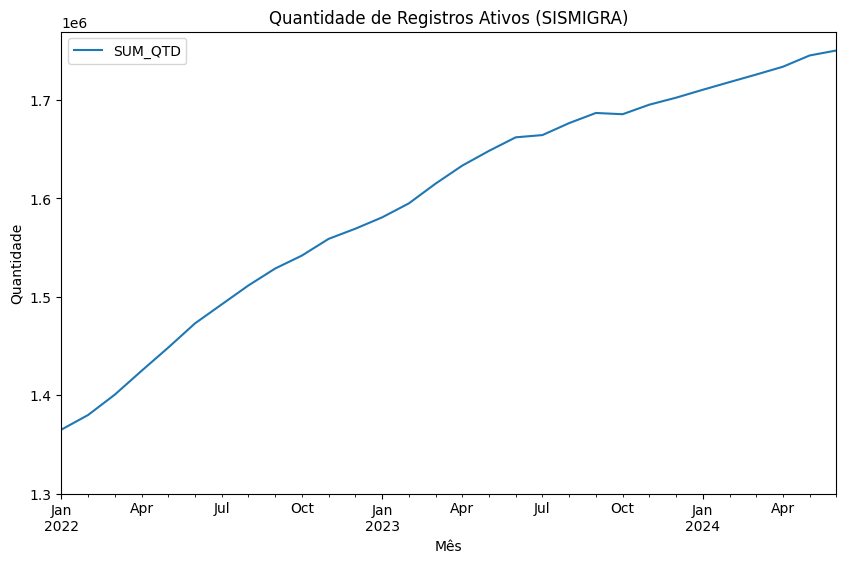

In [10]:
#Query Sazonalidade
import pandas as pd
import sqlite3
import numpy as np

# Reabrindo conexão com banco de dados
conn = sqlite3.connect('/content/drive/My Drive/Colab Notebooks/Versão Final MVP/SISMIGRA_Registros_Ativos.db')
cursor = conn.cursor()

query = '''
        SELECT SUM(S2.QTD) AS SUM_QTD, S2.MES
        FROM SISMIGRA_Registros_Ativos AS S2
        GROUP BY S2.MES
        ORDER BY SUM_QTD
        LIMIT 30
'''
df_from_db = pd.read_sql(query, conn)

df_from_db["MES"]= pd.to_datetime(df_from_db['MES'], format='%m-%Y')

df_from_db.sort_values("MES")

pivot = pd.pivot_table(df_from_db, values='SUM_QTD', index='MES')
pivot.plot(figsize=(10, 6), title='Quantidade de Registros Ativos (SISMIGRA)', xlabel='Mês', ylabel='Quantidade', yticks=np.arange(1300000, 1800000, 100000))
print(pivot)

conn.close()

De acordo com o output é possível perceber o aumento dos registros ativos com o passar dos meses.<br>


É correto então afirmar, baseado nos registros do SISMIGRA, que o fenômeno observado nas grandes metrópoles tem fundamento: o movimento migratório de estrangeiros para o Brasil segue em aumento desde janeiro de 2022 e em junho de 2024 o total de registros chegou a 1.750.393. <br>
Embora tenha havido uma aparente estabilização na linha do gráfico nos períodos jun/2023-jul/2023, set/2023-out/2023 os números de retorno nos auxiliam a perceber que houve apenas um menor crescimento, em comparação ao demais períodos.<br>

---
<br>

A query abaixo visa ilustrar os registros ativos de imigração de acordo com país de origem do imigrante limitado a 5 países que mais tiveram emigração para o Brasil. O escopo temporal é também jan/2022 a junho/2024

NACIONALIDADE  ARGENTINA  BOLÍVIA   HAITI  PORTUGAL  VENEZUELA
MES                                                           
2022-01-01         66384   103596  130738    181870     212103
2022-02-01         66961   104407  129650    181787     224023
2022-03-01         67533   105355  128790    181711     239244
2022-04-01         68129   106163  129892    181656     255260
2022-05-01         68759   107327  130991    181602     270307
2022-06-01         69499   109038  131675    181481     286302
2022-07-01         70178   111406  131939    181337     297660
2022-08-01         70903   114055  131530    181225     308794
2022-09-01         71604   116575  130749    181089     317911
2022-10-01         72162   117906  129951    181070     324901
2022-11-01         73024   120007  129026    181055     333820
2022-12-01         73621   121615  126828    180931     340144
2023-01-01         74240   122116  126285    180839     347690
2023-02-01         74692   123180  126033    180663    

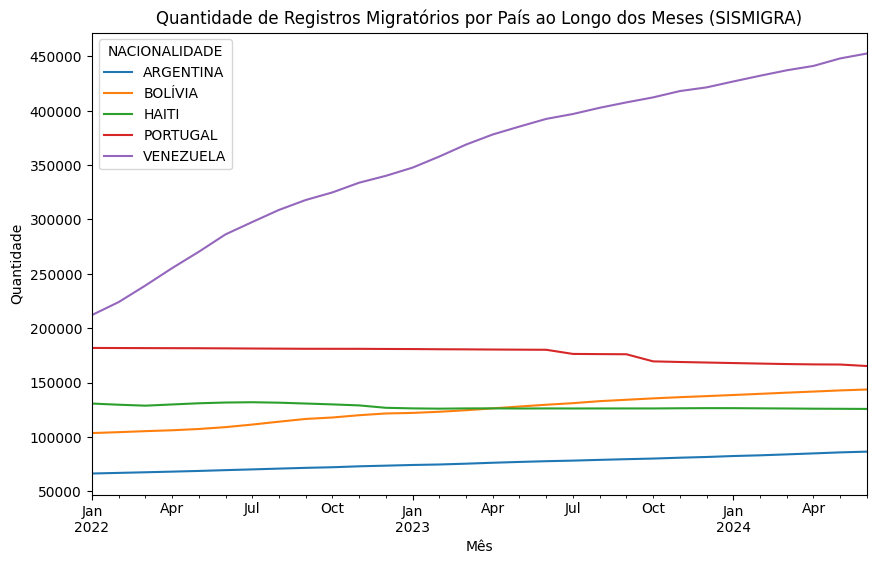

In [11]:
import pandas as pd
import sqlite3

# Reabrindo conexão com banco de dados
conn = sqlite3.connect('/content/drive/My Drive/Colab Notebooks/Versão Final MVP/SISMIGRA_Registros_Ativos.db')
cursor = conn.cursor()

query = '''
    SELECT S.NACIONALIDADE, SUM(S.QTD) AS QUANTIDADE, S.MES
    FROM SISMIGRA_Registros_Ativos AS S
        JOIN (
        SELECT SUM(S2.QTD) AS SUM_QTD, S2.NACIONALIDADE
        FROM SISMIGRA_Registros_Ativos AS S2
        GROUP BY S2.NACIONALIDADE
        ORDER BY SUM_QTD DESC
        LIMIT 5
    ) AS SUBQUERY ON S.NACIONALIDADE = SUBQUERY.NACIONALIDADE
    GROUP BY S.NACIONALIDADE, S.MES
'''
df_from_db = pd.read_sql(query, conn)
#print(df_from_db)

df_from_db["MES"]= pd.to_datetime(df_from_db['MES'], format='%m-%Y')

df_from_db.sort_values("MES")
pivot = pd.pivot_table(df_from_db, values='QUANTIDADE', index='MES', columns='NACIONALIDADE')
pivot.plot(figsize=(10, 6), title='Quantidade de Registros Migratórios por País ao Longo dos Meses (SISMIGRA)', xlabel='Mês', ylabel='Quantidade')
print(pivot)

conn.close()

O output acusa como países com maior número de emigrantes para o Brasil: Argentina, Bolívia, Haiti, Portugal e Venezuela
<br>
<br>

Percebe-se grande presença de países fronteiriços: Argentina, Bolívia (amparados ainda pelo Mercosul - sendo o segundo apenas Estado associado) e Venezuela. Também de Portugal, que mantém estreita relação com o Estado brasileiro e é Parte do Tratado de Amizade, Cooperação e Consulta entre a República Federativa do Brasil e a República Portuguesa. E o  Haiti, que se familliarizou com o Brasil após um terremoto, em 2010, e teve uma Missão da ONU liderada pelo Brasil: Missão Missão das Nações Unidas para a Estabilização do Haiti. Desde então o fluxo migratório para o Estado brasileiro é presente e mecanismos para assistencia aos imigrantes e refugiados foram criado.

Há uma facilitação da migração para o Brasil vinda da Argentina, Colômbia, Portugal e Haiti por conta dos Acordos mantidos e mecanismos de acolhimento. Ainda assim, o gráfico ilustra bem a disparidade entre os registros de imigração vinda desses países e do primeiro colocado (Venezuela). Em junho de 2024 o Brasil registrou 452.615 vistos para venezuelanos, no mesmo período, para o segundo colocado - Portugal - foram registrados 165.244 vistos. Uma diferença de 287.371 vistos entre eles.<br>
<br>
<br>

Após o resultado acima, para compreender ainda melhor o impacto das migrações venezuelanas neste panorama de migração, fez-se pertinente ilustrar a porcentagem de imigrantes desses 5 países em relação a todos os outros:<br>





  Nacionalidade  Porcentagem
0     VENEZUELA        22.41
1     ARGENTINA         4.76
2       BOLÍVIA         7.82
3         HAITI         8.00
4      PORTUGAL        11.05
5        OUTROS        45.97


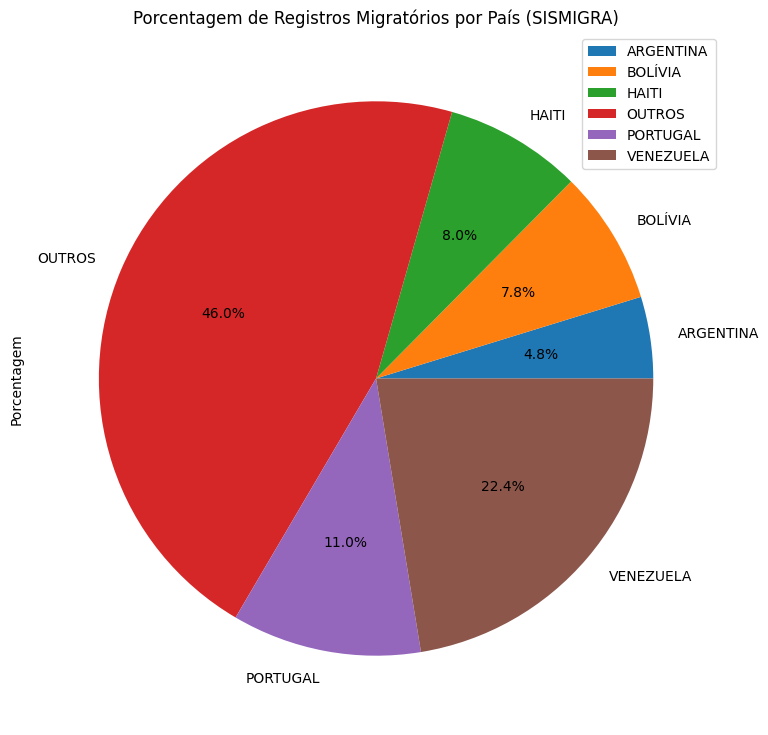

In [12]:
import pandas as pd
import sqlite3

# Reabrindo conexão com banco de dados
conn = sqlite3.connect('/content/drive/My Drive/Colab Notebooks/Versão Final MVP/SISMIGRA_Registros_Ativos.db')
cursor = conn.cursor()

query = '''

        SELECT SUM(QTD) AS TOTAL,
        SUM(CASE WHEN NACIONALIDADE = 'VENEZUELA' THEN QTD ELSE 0 END) AS VENEZUELA ,
        SUM(CASE WHEN NACIONALIDADE = 'ARGENTINA' THEN QTD ELSE 0 END) AS ARGENTINA,
        SUM(CASE WHEN NACIONALIDADE = 'BOLÍVIA' THEN QTD ELSE 0 END) AS BOLÍVIA,
        SUM(CASE WHEN NACIONALIDADE = 'HAITI' THEN QTD ELSE 0 END) AS HAITI,
        SUM(CASE WHEN NACIONALIDADE = 'PORTUGAL' THEN QTD ELSE 0 END) AS PORTUGAL,
        SUM(CASE WHEN NACIONALIDADE NOT IN ('VENEZUELA', 'ARGENTINA', 'BOLÍVIA', 'HAITI', 'PORTUGAL') THEN QTD ELSE 0 END) AS OUTROS
        FROM SISMIGRA_Registros_Ativos
        LIMIT 5

'''
df_from_db = pd.read_sql(query, conn)

df =pd.DataFrame({
  'Nacionalidade': ['VENEZUELA', 'ARGENTINA', 'BOLÍVIA', 'HAITI', 'PORTUGAL', 'OUTROS'],
  'Porcentagem': [
      round(df_from_db['VENEZUELA'][0] / df_from_db['TOTAL'][0] * 100, 2),
      round(df_from_db['ARGENTINA'][0] / df_from_db['TOTAL'][0] * 100, 2),
      round(df_from_db['BOLÍVIA'][0] / df_from_db['TOTAL'][0] * 100, 2),
      round(df_from_db['HAITI'][0] / df_from_db['TOTAL'][0] * 100, 2),
      round(df_from_db['PORTUGAL'][0] / df_from_db['TOTAL'][0] * 100, 2),
      round(df_from_db['OUTROS'][0] / df_from_db['TOTAL'][0] * 100, 2)
  ]
})
print(df)
df.groupby('Nacionalidade').sum().plot(kind='pie', autopct='%1.1f%%', y='Porcentagem', figsize=(9, 9), title='Porcentagem de Registros Migratórios por País (SISMIGRA)', ylabel='Porcentagem')

conn.close()

<br>

É possível notar que a porcentagem de registros de pessoas da Venezuela - excluindo os 4 países restantes com mais emigrantes - corresponde a quase metade do total de registros de todos os países juntos. Dentre todos os vistos registrados 22.41% foram concedidos a venezuelanos - o dobro do total concedido à portugueses (11%).

Assim como o Haiti há mais de uma década a Venezuela passa por uma crise humanitária, provocando o êxodo de milhões de venezuelanos. A vinda desse emigrantes para o Brasil se justifica - além de pela política externa que inseja "cooperação, democracia e prosperidade com justiça social" (PATRIOTA Antonio, 2013, p 31) - também pelo endurecimento das políticas migratórias do Chile e Peru e dificuldades impostas pela Colôbia e Equador. Dessa forma, as migrações, cada vez mais, têm como destino o Brasil.
<br>

**Fontes:** Política externa brasileira: discursos, artigos e entrevistas (janeiro a agosto de 2013) / Antonio de Aguiar Patriota. – Brasília : FUNAG, 2013-2016.
https://www.bbc.com/portuguese/articles/cv234k0y9p1o
<br>
<br>
<br>

---
<br>
<br>
Para as análises a seguir utilizamos o dataset do Sistema de Tráfego Internacional, que registra os movimentos de entrada e saída do país.
A query abaixo visa responder qual o maior fluxo de movimento de entrada no Brasil - por classificação do movimento: entrada permanente, temporária, para visita ou outros (não informada / especificada pela autor do dataset):


      TOTAL  PERMANENTE  TEMPORARIO  VISITANTE   OUTROS
0  11932756      859090      109765    8680023  2283878


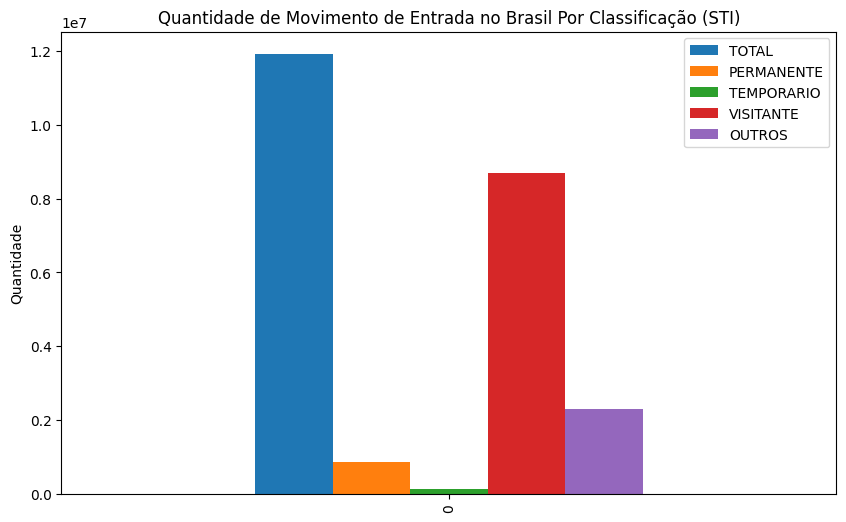

In [13]:
import pandas as pd
import sqlite3

# Reabrindo conexão com banco de dados
conn = sqlite3.connect('/content/drive/My Drive/Colab Notebooks/Versão Final MVP/STI_Movimento.db')
cursor = conn.cursor()

query = '''
    SELECT SUM(TOTAL) AS TOTAL,
    SUM(CASE WHEN CLASSIFICACAO = 'PERMANENTE' THEN TOTAL ELSE 0 END) AS PERMANENTE,
    SUM(CASE WHEN CLASSIFICACAO = 'TEMPORÁRIO' THEN TOTAL ELSE 0 END) AS TEMPORARIO,
    SUM(CASE WHEN CLASSIFICACAO = 'VISITANTE' THEN TOTAL ELSE 0 END) AS VISITANTE,
    SUM(CASE WHEN CLASSIFICACAO = 'OUTROS' THEN TOTAL ELSE 0 END) AS OUTROS
    FROM STI_Movimento
    WHERE NACIONALIDADE != 'BRASIL' AND TIPO = 'ENTRADA'
'''

df_from_db = pd.read_sql(query, conn)
print(df_from_db)

df_from_db.plot(kind='bar', figsize=(10, 6), title='Quantidade de Movimento de Entrada no Brasil Por Classificação (STI)', ylabel='Quantidade')

conn.close()

<br>

Observa-se que a quantidade de movimentos de entrada permantente e temporária são bastante inferiores às entradas com o propósito de visita. A soma de entradas permanentes e temporárias totaliza apenas 968.855, se distanciando do total de "visita" por 7.711.168 entradas.<br>
Ainda que não seja proposta desse trabalho e que não seja possível fazê-lo com os datasets em questão, é pertinente a verificação da conversão dos movimentos de visitante para imigrante (vistos requeridos após entrada no país). Também a verificação da informação "Outros" - a que atribuem essa classificação de movimento.
<br>
<br>

Para melhor dimensionamento, veremos em porcentagem as informações sobre os movimentos de entrada no Brasil:




  Classificação  Porcentagem
0    PERMANENTE         7.20
1    TEMPORARIO         0.92
2     VISITANTE        72.74
3        OUTROS        19.14


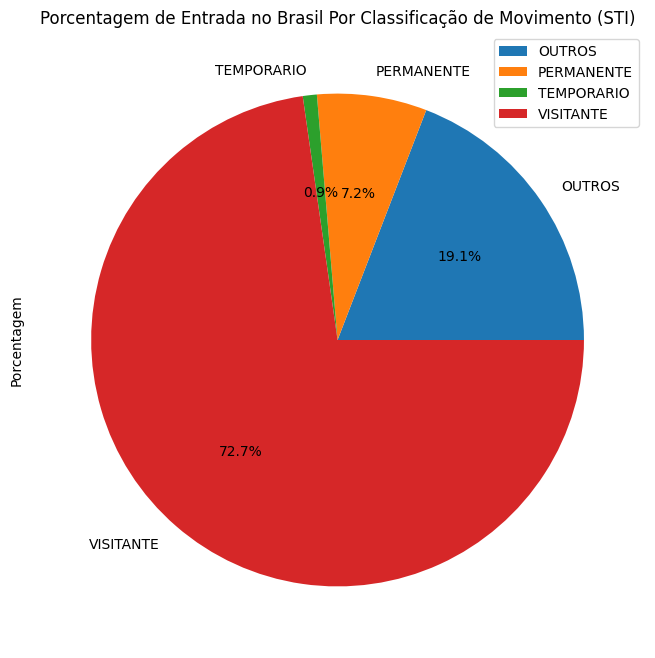

In [14]:
import pandas as pd
import sqlite3

# Reabrindo conexão com banco de dados
conn = sqlite3.connect('/content/drive/My Drive/Colab Notebooks/Versão Final MVP/STI_Movimento.db')
cursor = conn.cursor()

query = '''
    SELECT SUM(TOTAL) AS TOTAL,
    SUM(CASE WHEN CLASSIFICACAO = 'PERMANENTE' THEN TOTAL ELSE 0 END) AS PERMANENTE,
    SUM(CASE WHEN CLASSIFICACAO = 'TEMPORÁRIO' THEN TOTAL ELSE 0 END) AS TEMPORARIO,
    SUM(CASE WHEN CLASSIFICACAO = 'VISITANTE' THEN TOTAL ELSE 0 END) AS VISITANTE,
    SUM(CASE WHEN CLASSIFICACAO = 'OUTROS' THEN TOTAL ELSE 0 END) AS OUTROS
    FROM STI_Movimento
    WHERE NACIONALIDADE != 'BRASIL' AND TIPO = 'ENTRADA'
    '''

df_from_db = pd.read_sql(query, conn)

df=pd.DataFrame({
    "Classificação": [
        "PERMANENTE",
        "TEMPORARIO",
        "VISITANTE",
        "OUTROS"
    ],
    "Porcentagem": [
        round(df_from_db['PERMANENTE'][0] / df_from_db['TOTAL'][0] * 100, 2),
        round(df_from_db['TEMPORARIO'][0] / df_from_db['TOTAL'][0] * 100, 2),
        round(df_from_db['VISITANTE'][0] / df_from_db['TOTAL'][0] * 100, 2),
        round(df_from_db['OUTROS'][0] / df_from_db['TOTAL'][0] * 100, 2)
    ]
})

print(df)

df.groupby('Classificação').sum().plot(kind='pie', autopct='%1.1f%%', y='Porcentagem', figsize=(8, 8), title='Porcentagem de Entrada no Brasil Por Classificação de Movimento (STI)', ylabel='Porcentagem')

conn.close()

É notória a quantidade massiva de visitantes no fluxo de entrada de pessoas no Brasil, é 72.7% dos processos.
<br>
<br>

A segunda maior porção é "Outros", que supera em 11% os movimentos temporários e permanentes. <br>
<br>


---

<br>
<br>

Notado o grande volume de visitantes no Brasil, faz-se pertinente especular sobre o movimento de saída dos brasileiros do país:

      TOTAL  SAÍDA DE BRASILEIROS  ENTRADA DE ESTANGEIROS 
0  22147103              10214347                 11932756


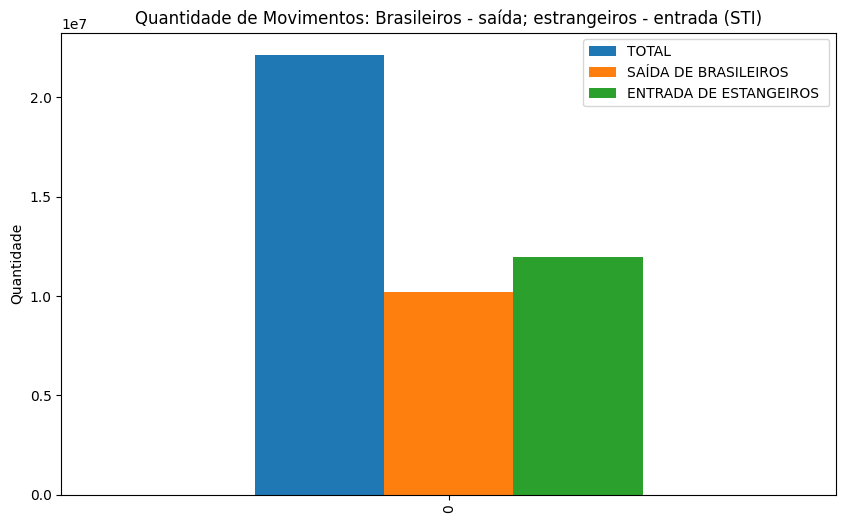

In [15]:
import pandas as pd
import sqlite3

# Reabrindo conexão com banco de dados
conn = sqlite3.connect('/content/drive/My Drive/Colab Notebooks/Versão Final MVP/STI_Movimento.db')
cursor = conn.cursor()

query = '''

    SELECT
    SUM(CASE WHEN (NACIONALIDADE = 'BRASIL' AND TIPO = 'SAIDA') OR (NACIONALIDADE != 'BRASIL' AND TIPO = 'ENTRADA') THEN TOTAL ELSE 0 END) AS "TOTAL",
    SUM(CASE WHEN NACIONALIDADE = 'BRASIL' AND TIPO = 'SAIDA' THEN TOTAL ELSE 0 END) AS "SAÍDA DE BRASILEIROS",
    SUM(CASE WHEN NACIONALIDADE != 'BRASIL' AND TIPO = 'ENTRADA' THEN TOTAL ELSE 0 END) AS "ENTRADA DE ESTANGEIROS "
    FROM STI_Movimento

'''

df_from_db = pd.read_sql(query, conn)
print(df_from_db)

df_from_db.plot(kind='bar', figsize=(10, 6), title='Quantidade de Movimentos: Brasileiros - saída; estrangeiros - entrada (STI)', ylabel='Quantidade')

conn.close()

O número de movimentos de entrada no país supera o total de saída de brasileiros.<br>
<br>

É válido notar que a query não delimita os movimentos de entrada e saída por classificação, portanto a análise é ainda ampla. Não é possível saber se o movimento registrado deve ser tratado como imigração ou "passeio", por exemplo. <br>
A diferença é de 1.718.409 entre o movimento de saída de brasileiros e entrada de estrangeiros. Para ter uma dimensão mais prática desse dado, abaixo está a proporção entre os movimentos:


   Brasileiros  Estrangeiros
0          9.0          12.0


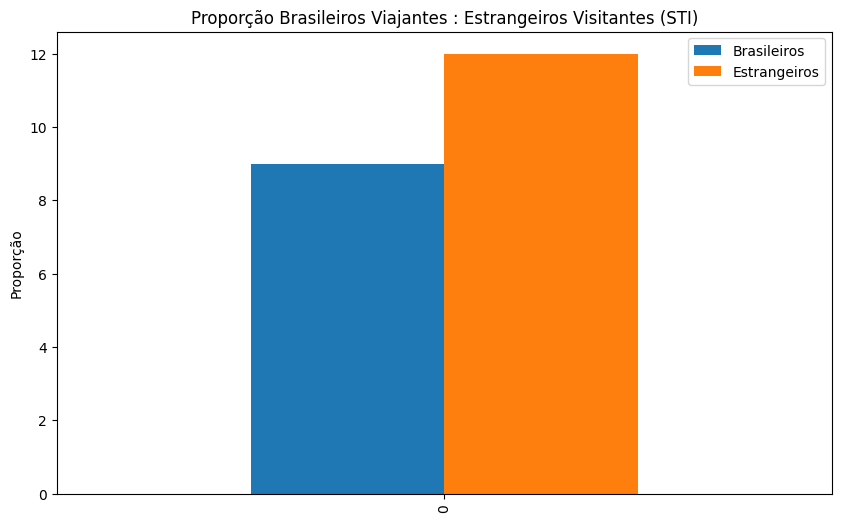

In [16]:
import pandas as pd
import sqlite3

# Reabrindo conexão com banco de dados
conn = sqlite3.connect('/content/drive/My Drive/Colab Notebooks/Versão Final MVP/STI_Movimento.db')
cursor = conn.cursor()

query = '''

    SELECT
    SUM(CASE WHEN NACIONALIDADE = 'BRASIL' AND TIPO = 'SAIDA' THEN TOTAL ELSE 0 END) AS "BRASILEIROS VIAJANTES",
    SUM(CASE WHEN NACIONALIDADE != 'BRASIL' AND TIPO = 'ENTRADA' THEN TOTAL ELSE 0 END) AS "ESTANGEIROS VISITANTES"
    FROM STI_Movimento

'''

df_from_db = pd.read_sql(query, conn)

df = pd.DataFrame({
    "Brasileiros": [round(df_from_db['BRASILEIROS VIAJANTES'][0] / df_from_db['ESTANGEIROS VISITANTES'][0] * 10, 0)],
    "Estrangeiros": [round(df_from_db['ESTANGEIROS VISITANTES'][0] / df_from_db['BRASILEIROS VIAJANTES'][0] * 10, 0)]
})
print(df)
df.plot(kind='bar', figsize=(10, 6), title='Proporção Brasileiros Viajantes : Estrangeiros Visitantes (STI)', ylabel='Proporção')

conn.close()

Na escala acima é possível notar o gap entre os movimentos com maior precisão:
Para cada 9 brasileiros que deixam o país (com variados propósitos) há 12 pessoas das mais diversas nacionalidades entrando pelas fronteiras do Brasil.

<br>
<br>

---

<br>
<br>

Após ter uma panorama sobre os movimentos na fronteiras brasileiras, nos voltaremos mais uma vez para os dados do Sistema de Registro Nacional Migratório para verificar, dessa vez, o impacto da migração no Brasil.
<br>
Na query a seguir vê-se os registros migratórios das 5 cidades brasileiras que foram porta de entrada para imigrantes por mais vezes:


      TOTAL        SP       RJ       SC       RR       PR
0  47923918  18033330  5171405  3569086  3967673  3934541


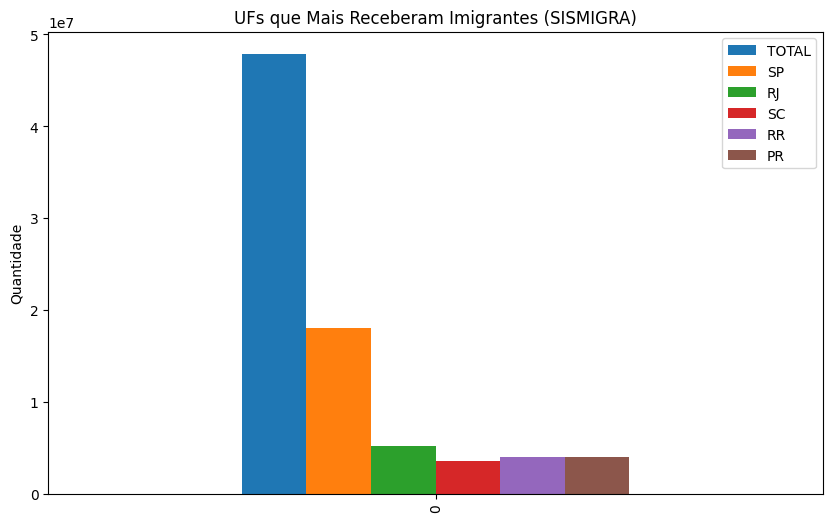

In [17]:
import pandas as pd
import sqlite3

# Reabrindo conexão com banco de dados
conn = sqlite3.connect('/content/drive/My Drive/Colab Notebooks/Versão Final MVP/SISMIGRA_Registros_Ativos.db')
cursor = conn.cursor()

query = '''
        SELECT SUM(QTD) AS TOTAL,
        SUM(CASE WHEN UF = 'SP' THEN QTD ELSE 0 END) AS SP,
        SUM(CASE WHEN UF = 'RJ' THEN QTD ELSE 0 END) AS RJ,
        SUM(CASE WHEN UF = 'SC' THEN QTD ELSE 0 END) AS SC,
        SUM(CASE WHEN UF = 'RR' THEN QTD ELSE 0 END) AS RR,
        SUM(CASE WHEN UF = 'PR' THEN QTD ELSE 0 END) AS PR
        FROM SISMIGRA_Registros_Ativos
'''
df_from_db = pd.read_sql(query, conn)
print(df_from_db)

df_from_db.plot(kind='bar', figsize=(10, 6), title='UFs que Mais Receberam Imigrantes (SISMIGRA)', ylabel='Quantidade')

conn.close()

As 5 UFs que mais apresentaram ocorrencia de migração foram Paraná, Rio de Janeiro, Roraima, Santa Catarina e São Paulo.
<br>
Para este trabalho assumiu-se que o local de entrada é também o local onde o imigrante se fixará, ainda que o trânsito entre cidades seja possível, e próvavel, em muitos casos.<br>
Dessa forma, ao analisarmos os resultados vê-se uma diferença muito grande entre as UFs, que tem como grande receptora São Paulo.
Na sequencia está Rio de Janeiro, com menos da metade de ocorrencias.
Surpreende o baixo - se comparado a SP - número de migrações tendo Roraima como porta de entrada, uma vez que identificamos a Venezuela com maioria absoluta das emigrações. <br>
Não pode ser descartada a possibilidade de conversão de visitantes para imigrantes e da insuficiencia de vigilancia nas fronteiras.
Ainda que o número surpreenda, sabe-se que SP é tida como um polo empregador, sendo uma das justificativas para o alto número em relação as demais UFs. Às regiões sul e sudeste é atribuida a ideia de melhor empregabilidade e qualidade de vida.

       UF  Porcentagem
0      SP        37.63
1      RJ        10.79
2      SC         7.45
3      RR         8.28
4      PR         8.21
5  OUTROS        27.64


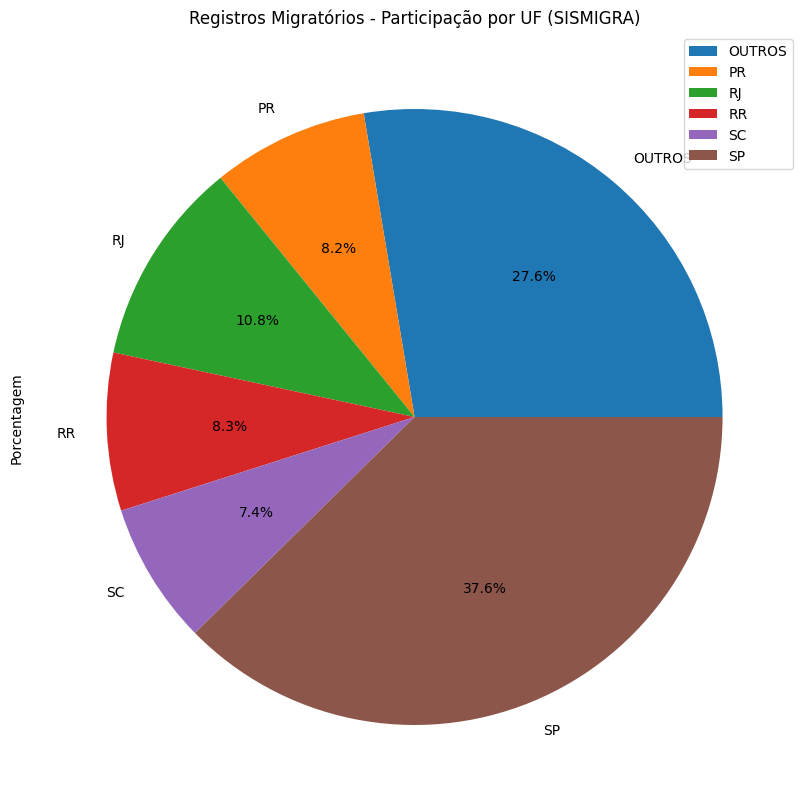

In [18]:
import pandas as pd
import sqlite3

# Reabrindo conexão com banco de dados
conn = sqlite3.connect('/content/drive/My Drive/Colab Notebooks/Versão Final MVP/SISMIGRA_Registros_Ativos.db')
cursor = conn.cursor()

query = '''
        SELECT SUM(QTD) AS TOTAL,
        SUM(CASE WHEN UF = 'SP' THEN QTD ELSE 0 END) AS SP,
        SUM(CASE WHEN UF = 'RJ' THEN QTD ELSE 0 END) AS RJ,
        SUM(CASE WHEN UF = 'SC' THEN QTD ELSE 0 END) AS SC,
        SUM(CASE WHEN UF = 'RR' THEN QTD ELSE 0 END) AS RR,
        SUM(CASE WHEN UF = 'PR' THEN QTD ELSE 0 END) AS PR,
        SUM(CASE WHEN UF NOT IN ('SP', 'RJ', 'SC', 'RR', 'PR') THEN QTD ELSE 0 END) AS OUTROS
        FROM SISMIGRA_Registros_Ativos
'''
df_from_db = pd.read_sql(query, conn)

df = pd.DataFrame({
    'UF': ['SP', 'RJ', 'SC', 'RR', 'PR', 'OUTROS'],
    'Porcentagem': [
        round(df_from_db['SP'][0] / df_from_db['TOTAL'][0] * 100, 2),
        round(df_from_db['RJ'][0] / df_from_db['TOTAL'][0] * 100, 2),
        round(df_from_db['SC'][0] / df_from_db['TOTAL'][0] * 100, 2),
        round(df_from_db['RR'][0] / df_from_db['TOTAL'][0] * 100, 2),
        round(df_from_db['PR'][0] / df_from_db['TOTAL'][0] * 100, 2),
        round(df_from_db['OUTROS'][0] / df_from_db['TOTAL'][0] * 100, 2)
    ]
    })

print(df)

df.groupby('UF').sum().plot(kind='pie', autopct='%1.1f%%', y='Porcentagem', figsize=(10, 10), title='Registros Migratórios - Participação por UF (SISMIGRA)', ylabel='Porcentagem')

conn.close()

São Paulo recebeu 37.6% do total de imigrantes no Brasil.

Trata-se de um número bastante expressivo, nem a soma dos outros dois estados que mais receberam imigrantes - Roraima e Rio de Janeiro - alcançaria SP. As 5 UFs juntas receberam 72,4% dos imigrantes, sendo a soma de todas as outras UFs equivalente a 27,6%
<br>
<br>
<br>

Para maior detalhamento do processo migratórios nesses estados abaixo está o registro das migrações ao longo dos 2 anos e meio que compõem o escopo temporal desse trabalho:


UF              PR      RJ      RR      SC      SP
MES                                               
2022-01-01   98984  168239   86546   83227  549764
2022-02-01  100620  168509   91426   84923  552459
2022-03-01  102377  169209   97466   87067  556059
2022-04-01  105287  169914  103408   89499  559868
2022-05-01  108565  170698  108401   91678  564575
2022-06-01  111429  171459  113296   94340  569278
2022-07-01  113828  171902  116782   96708  573983
2022-08-01  116498  172412  120782   99518  579069
2022-09-01  118651  172975  124835  102202  583865
2022-10-01  120800  173586  127108  104181  587281
2022-11-01  123399  174352  129919  107306  591808
2022-12-01  124537  174579  131254  109274  594707
2023-01-01  126313  174918  133535  111471  595487
2023-02-01  128065  174934  136299  113894  598326
2023-03-01  130723  175572  138842  116807  603131
2023-04-01  132881  176193  140741  120063  608151
2023-05-01  135325  176740  142452  123277  612602
2023-06-01  137624  177106  144

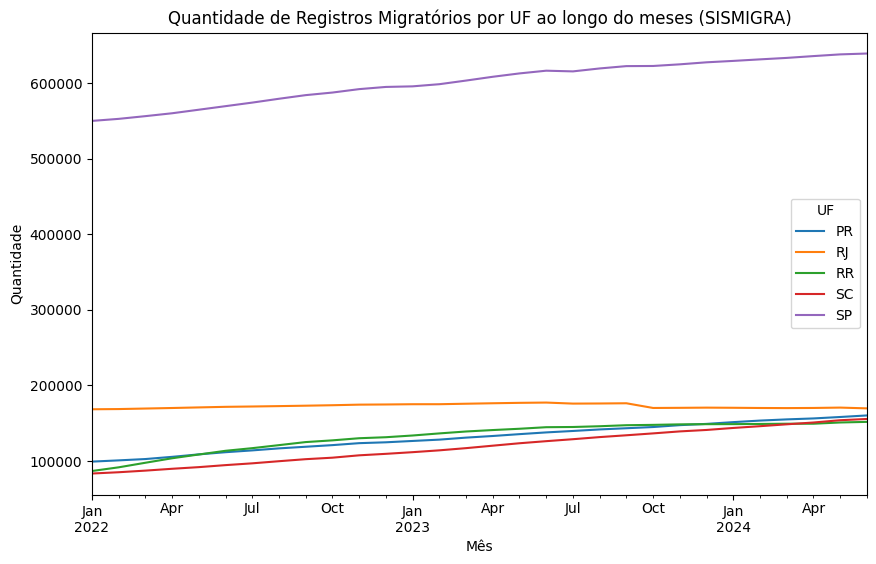

In [19]:
import pandas as pd
import sqlite3

# Reabrindo conexão com banco de dados
conn = sqlite3.connect('/content/drive/My Drive/Colab Notebooks/Versão Final MVP/SISMIGRA_Registros_Ativos.db')
cursor = conn.cursor()

query = '''
    SELECT S.UF, SUM(S.QTD) AS QUANTIDADE, S.MES
    FROM SISMIGRA_Registros_Ativos AS S
        JOIN (
        SELECT SUM(S2.QTD) AS SUM_QTD, S2.UF
        FROM SISMIGRA_Registros_Ativos AS S2
        GROUP BY S2.UF
        ORDER BY SUM_QTD DESC
        LIMIT 5
    ) AS SUBQUERY ON S.UF = SUBQUERY.UF
    GROUP BY S.UF, S.MES
'''
df_from_db = pd.read_sql(query, conn)

df_from_db["MES"]= pd.to_datetime(df_from_db['MES'], format='%m-%Y')

df_from_db.sort_values("MES")
pivot = pd.pivot_table(df_from_db, values='QUANTIDADE', index='MES', columns='UF')
pivot.plot(figsize=(10, 6), title='Quantidade de Registros Migratórios por UF ao longo do meses (SISMIGRA)', xlabel='Mês', ylabel='Quantidade')
print(pivot)

conn.close()

#### Conclusão:

Embora tenha surgido de uma inferencia particular a temática, problema e perguntas desse trabalho, os dados confirmam o que se vê a olhos nus: há uma presença massiva e crescente de pessoas de outras nacionalidades nas cidades Brasil a fora.
De acordo com dados do Instituto Brasileiro de Geografia e Estatística (IBGE), divulgados em 2023: "nem 6% dos municípios com imigrantes possuem uma estrutura para gestão migratória. Foi mencionado que a maioria dos estados e municípios não têm servidores ou cidadãos que conheçam as condições sanitárias, econômicas, de saúde e educação da população imigrante."

É de suma importancia a criação mecanismos de acolhimento e políticas públicas para inserção de imigrantes na sociedade de forma digna.
Nesse sentido os dados apontaram um norte, deram a conhecer para onde essas ações devem se voltar - tendo São Paulo como foco e com quem essas ações devem dialogar: atualmente com a enorme e expressiva quantidade de venezuelanos com vistos ativos no país (e também os que ainda não).

Ainda que algumas perguntas relevantes tenham sido respondidas, o trabalho não se encerra aqui. Outras questões surgiram ao longo do processo - mais específicas - que poderiam ter sido executadas e analisadas, se houvesse mais tempo. Para além do tempo, a falta de explicação sobre os dados dos dataset por parte do autor não permitiram o avanço desejado.
<br>
<br>


**Fonte:** https://www12.senado.leg.br/radio/1/noticia/2023/09/14/acolhimento-de-imigrantes-e-refugiados-no-brasil-precisa-melhorar-na-maioria-dos-municipios



